In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"

In [2]:
sigma_eps = 0.0

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

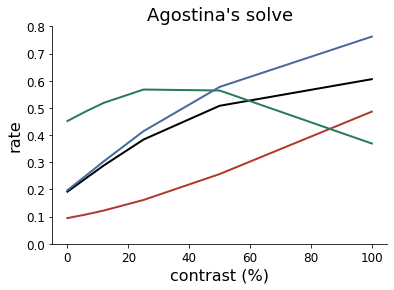

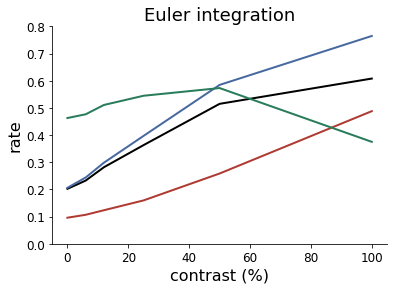

In [3]:
def plot_contrast_response(x, title):
    c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
    assert(x.shape[0] == c.shape[0])
    fig = plt.figure()
    for i in range(4):
        plt.plot(100*c, x[:,i], c=colors[i])
    plt.ylim([0., .8])
    plt.xlabel('contrast (%)')
    plt.ylabel('rate')
    plt.title(title)
    return fig

ind = 483
x_agos = load_SSSN_variable('rates', ind=ind).numpy()
plot_contrast_response(x_agos.T, "Agostina's solve")
plt.show()

c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
W = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

hs = hb[None,:] + c[:,None]*hc[None,:]
x_ss = SSSN_sim(hs).numpy()
plot_contrast_response(x_ss[:,0,:], "Euler integration")
plt.show()

#x_ss_tfp = SSSN_sim_tfp(hs)
#plot_contrast_response(x_ss_tfp[:,0,:], "TFP integration")
#plt.show()

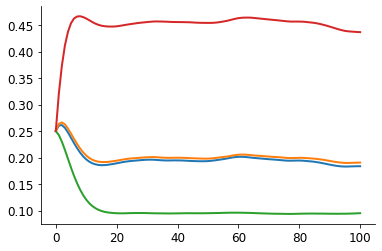

In [4]:
x_t = SSSN_sim_traj(hs).numpy()
plt.plot(x_t[0,0,:4,:].T)

In [5]:
HB = load_SSSN_variable('hb', ind=0)
HC = load_SSSN_variable('hc', ind=0)

lb = -.1*np.ones((4,))
ub = .1*np.ones((4,))
dh = Parameter("dh", 4, lb=lb, ub=ub)
parameters = [dh]

def SV_flip(dh):
    h = HB[None,:] + dh
    
    hc = HC[None,:]
   
    ss1 = SSSN_sim(h)[:,:,:4]
    ss2 = SSSN_sim(h+hc)[:,:,:4]
    
    diff1 = (ss1[:,:,2]-ss1[:,:,3]) / tf.norm(ss1, axis=2, keepdims=False)
    diff2 = (ss2[:,:,2]-ss2[:,:,3]) / tf.norm(ss2, axis=2, keepdims=False)
    diff_prod = tf.reduce_mean(diff1*diff2, axis=1)
    diff_sum = tf.reduce_mean(diff1+diff2, axis=1)
    T_x = tf.stack((diff_prod, 
                    diff_sum), axis=1)

    return T_x

# Define model
name = "SSSN"
model = Model(name, parameters)
model.set_eps(SV_flip)

In [6]:
T_x = model.eps(np.zeros((1,4)))

In [7]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])

M = 1000
num_keep = 1000

diff_prod_mean = -0.1
mean = [diff_prod_mean]
std = [np.abs(diff_prod_mean)/4.]
def accept_inds(T_x, mean ,std):
    return np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])
    #return np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
    #                      np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

KeyboardInterrupt: 

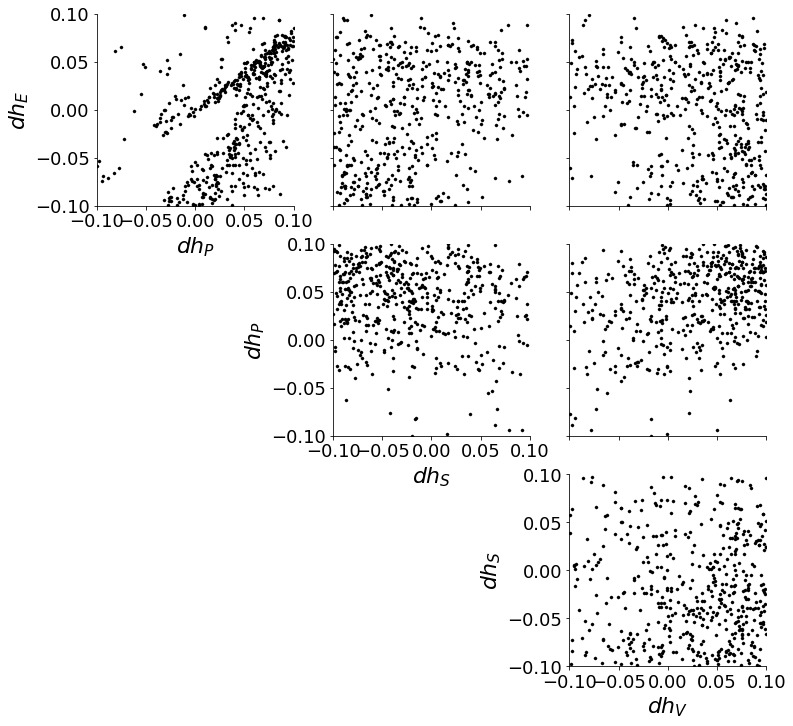

In [40]:
num_plot = 500
fontsize = 14
z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
fig = pairplot(z[:num_plot], np.arange(4), z_labels,
               fontsize=22,
               lb=lb, ub=ub)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')

(1000, 1, 8, 101)


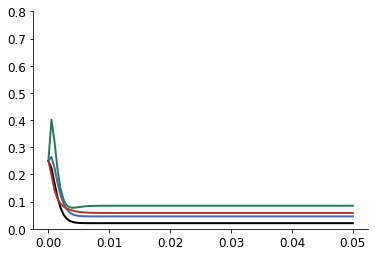

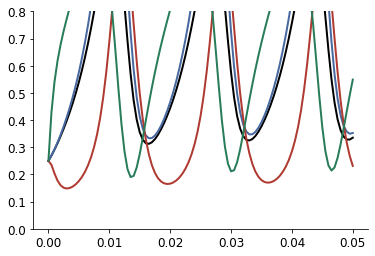

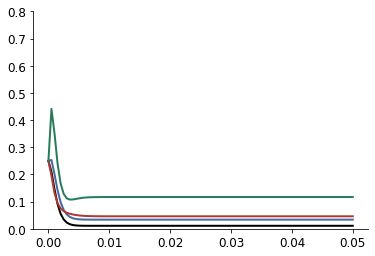

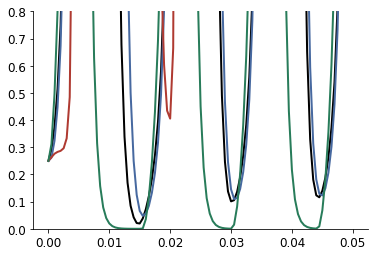

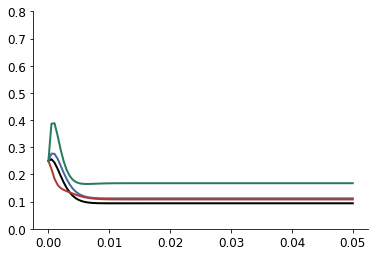

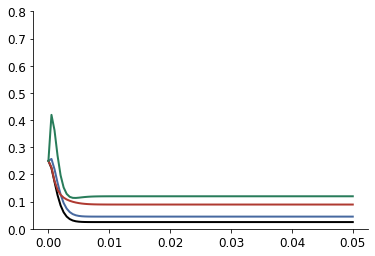

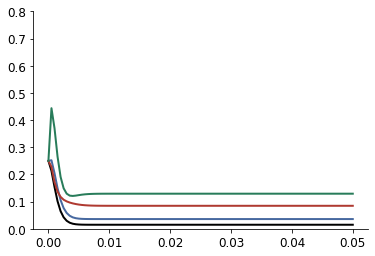

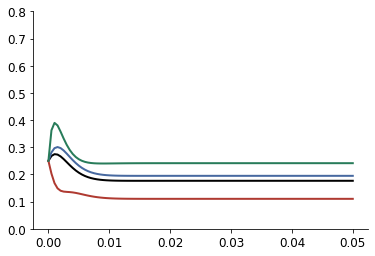

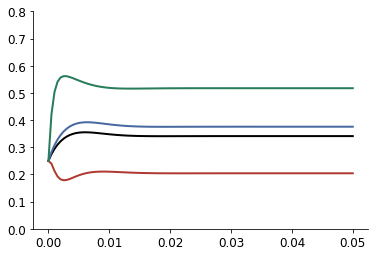

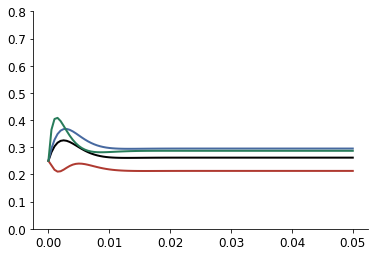

In [43]:
hs = z + HB[None,:]
x_t = SSSN_sim_traj(hs).numpy()
print(x_t.shape)
dt = 0.0005
t = dt*np.arange(101)
for j in range(10):
    plt.figure()
    for i in range(4):
        plt.plot(t, x_t[j,0,i,:].T, c=colors[i])
    plt.ylim([0, .8])
    plt.show()

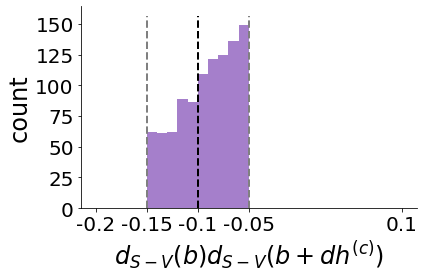

In [49]:
from epi.util import plot_T_x

# select by mu
mu = np.array([-0.1, 0.025**2])
    
T_x = model.eps(z).numpy()
xmins = [-.2]
xmaxs = [.1]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh^{(c)})$"]
i=0
plot_T_x(None, T_x[:,i], xmin=xmins[i], xmax=xmaxs[i], 
         x_mean = mu[i], x_std = np.sqrt(mu[i+1]),
         xlabel=xlabels[i], fontsize=24)
plt.tight_layout()
plt.savefig(figdir + 'SVflip_Tx1.png')

In [39]:
dt = 0.005
T = 100
def plot_responses(z):
    h = z[:4]
    dh = z[4]
    gamma = np.concatenate((np.array([0., 1.]), np.linspace(-.1, 3., 101)), axis=0)
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    _h = h + dh*gamma[:,None]*dh_pattern
    r_t = SSSN_sim_traj(_h).numpy()
    #T_x = SSN_stats(_h)
    
    neurons = ['E', 'P', 'S', 'V']
    
    t = dt*np.arange(T+1)
    for gamma_ind in [0, 1]:
        plt.figure()
        for neuron in neurons:
            ind = neuron_inds[neuron]
            plt.plot(t, r_t[gamma_ind,0,ind,:], c=colors[ind], lw=3)
        plt.plot([t[0], t[-1]], [-70, -70], 'k--', lw=3)
        h_gamma = _h[gamma_ind]
        plt.title('h = [%.2f %.2f %.2f %.2f]mV' % tuple([h_gamma[j] for j in range(4)]))
        plt.xlabel('time')
        plt.ylabel(r'$r_\alpha(t)$')
        plt.legend(neurons, title=r'$\alpha$')
        plt.show()
    
        
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    for neuron in neurons:
        ind = neuron_inds[neuron]
        ax.plot(gamma[2:], r_t[2:,0,ind,-1], c=colors[ind], lw=3)
    ax.set_ylabel('r')
    plt.show()
    return None

for i in range(4):
    plot_responses(z[i])


IndexError: index 4 is out of bounds for axis 0 with size 4